# Creating Ridge Plots from FlowJo exported Flow Cytometry Histograms

In [332]:
# Directory stuff
import os

# Dataframe stuff
import pandas as pd
import numpy as np

# Viz stuff
import seaborn as sns
from matplotlib import pyplot as plt

In [87]:
%matplotlib inline

## Loading Data

1. **ISSUE**: FlowJo does not let you name subpopulations and is absolutely useless in this area.
    1. Workaround: create your own keyword and add the sample name in here. You can choose this keyword when setting file naming patterns.
2. Load all csvs in a directory, use file name to name sample name.
    1. **ISSUE**: Naming files with things like "0.5" breaks file. Tried using "1:2" to represent this idea. Probably want to use "0,5" instead next time because FlowJo output "1:2ul" as "12ul"
3. Convert into tidy format
4. Concatenate together into single experiment dataframe

## Single Sample Loading (Testing)

In [259]:
data = pd.read_csv("/Users/adrian/code/lab/tc_tools/inputs/L16 QKRR 8ul.csv")
data.head(10)

,FITC-A,Time
0,5544.7,0.566551
1,22099.7,0.568646
2,15812.3,0.569693
3,26119.1,0.570740
4,1348.2,0.571788
5,4442.9,0.578071
6,6129.9,0.579118
7,3657.5,0.585402
8,8145.9,0.586449
9,5981.5,0.587496


# Single Histogram plotting (testing)

1. Export Sample > Alive > Singles from FlowJo as **FITC-A vs Time**
2. **DO NOT** export as histogram. Trying to regraph their binned data causes issues.
3. Use log-scale on FITC-A axis and set bins=256

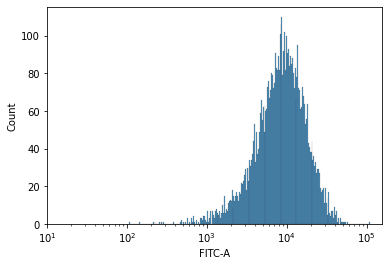

In [181]:
fig,axs = plt.subplots()
sns.histplot(ax=axs,data=g,x="FITC-A",log_scale=True,bins=256)
axs.set_xticks([1e1,1e2,1e3,1e4,1e5])

## Directory Loading

In [333]:
flow_dir = "/Users/Adrian/Documents/research/flow"
export_dir = "exports"

# This is the experiment directory you choose
exp_dir = "2021 12-21 jurkat exp check"
csv_dir= f"{flow_dir}/{exp_dir}/{export_dir}"

In [167]:
# Loads in CSVs and creates Sample column to concatenate CSVs in tidy format
def load_csvs(csv_dir):
    csvs = [f for f in os.listdir(csv_dir) if f.endswith(".csv")]
    
    dfs = []
    for csv in csvs:
        sample_name = csv.split(".")[0]
        df = pd.read_csv(f"{csv_dir}/{csv}")
        rows = df.shape[0]
        df["Sample"] = [sample_name]*rows
        dfs.append(df)
    exp_df = pd.concat(dfs,ignore_index=True)
    return exp_df

In [168]:
exp_df = load_csvs(csv_dir)

In [311]:
exp_df

,FITC-A,Time,Sample
0,20371.4,0.508186,L16 E34
1,17880.8,0.512243,L16 E34
2,5837.3,0.514272,L16 E34
3,27633.2,0.525430,L16 E34
4,16207.1,0.545716,L16 E34
...,...,...,...
143824,10818.5,21.568200,L16 QKRR Hi
143825,8450.4,21.568200,L16 QKRR Hi
143826,3182.2,21.573500,L16 QKRR Hi
143827,3894.1,21.574600,L16 QKRR Hi


## Break down name into descriptive columns

1. Programmatically tokenize sample name into individual columns:
    1. L16 QKRR 8ul --> Lag Binder, CAM name, Virus Concentration
    2. **Issues** we need to adapt this for different situations, can't do it unsupervised (I don't think?)
    3. Standardized naming convention? Just fill in missing data

## Subsetting DF

In [330]:
subset = pd.DataFrame(exp_df)

# NOTE: files couldnt handle 0.5ul so i wrote 1:2 ul but then pandas loaded it as 12ul -___-                
split_df = subset["Sample"].str.split(" ",expand=True)  
subset[["Lag Binder","CAM", "Virus Conc"]] = split_df
subset.head(10)

,FITC-A,Time,Sample,Lag Binder,CAM,Virus Conc
0,20371.4,0.508186,L16 E34,L16,E34,None
1,17880.8,0.512243,L16 E34,L16,E34,None
2,5837.3,0.514272,L16 E34,L16,E34,None
3,27633.2,0.525430,L16 E34,L16,E34,None
4,16207.1,0.545716,L16 E34,L16,E34,None
5,9055.9,0.555860,L16 E34,L16,E34,None
6,20107.5,0.576147,L16 E34,L16,E34,None
7,22719.2,0.581218,L16 E34,L16,E34,None
8,7875.7,0.586290,L16 E34,L16,E34,None
9,40397.0,0.611649,L16 E34,L16,E34,None


## New Ridgeplot (WIP)

In [301]:
def ridgeplot(df,by):
    # TODO: get more colors?
    # List of separable colors
    colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
          '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', 
          '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', 
          '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080']
    samples = df.groupby(by)
    num_samples = len(samples)
    overlap=0.5

    # TODO: figsize scaled by number and spacing of overlap
    # TODO: add a title
    fig,axs = plt.subplots(num_samples,figsize=(10,10+num_samples*overlap))
    for i,sample in enumerate(samples):
        sample_name, sample_df = sample
        kde_line = sns.kdeplot(data=sample_df,ax=axs[i],x="FITC-A",log_scale=True,
                   bw_adjust=0.3,color=colors[i],fill=True)
        axs[i].set_xticks([1e0,1e1,1e2,1e4,1e5,1e6])

        # TODO: change line color
        # TODO: change fill color

        # Set the background transparent
        axs[i].patch.set_alpha(0)

        # Turns off the axes for everything EXCEPT the last one
        if i != num_samples-1:
            axs[i].axis("off")

        # Last axes just disable y label and ticks
        axs[i].set_ylabel("")    
        axs[i].tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,
        labelleft=False) # labels along the bottom edge are off

        # Remove all spines    
        spines = ["left","top","right","bottom"]
        for spine in spines:
            axs[i].spines[spine].set_visible(False)

        # Sample labels
        # transform places coords wrt each axes
        axs[i].text(-0.1,0.1,sample_name,fontweight="bold",fontsize=24,color=colors[i],transform=axs[i].transAxes)
        #print(i,colors[i])
    # Overlap subplots
    plt.subplots_adjust(hspace=-overlap)
    plt.show()    
    
    # TODO: return a plot that can be grouped together with other plots? maybe?

/Users/adrian/code/lab/tc_tools/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


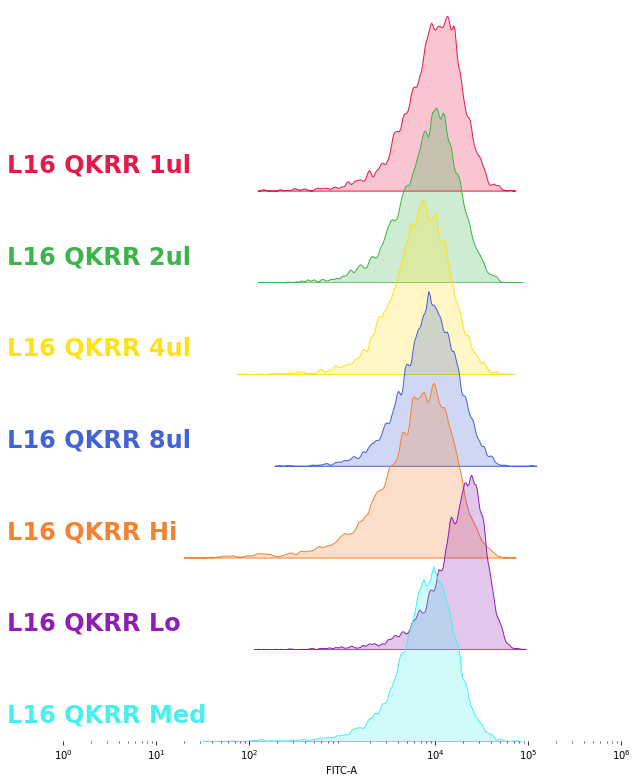

In [298]:
ridgeplot(lag16_qkrr,"Sample")

## Old RidgePlot

In [11]:
def ridge_plot(df):
    sns.set_style("white")
    # List of separable colors
    colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
          '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', 
          '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', 
          '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080']
    
    # FlowJo seems to give populations as columns and bins is fluoresence intensities corrected and binned?
    populations = [col for col in df.columns]
    rows = len(populations)
    
    #print(f"Generating {rows} rows in figure...")
    # Create figure rows based on number of populations
    fig,axs = plt.subplots(rows,1,figsize=(20,10))

    # NOTE: this could probably be done with a groupby
    # Need to iterate over populations
    for i,pop in enumerate(populations):
        #print(i,pop)
        
        # White line for density to make boundaries pop more
        plot = df[pop].plot.kde(ax=axs[i],color="white", linewidth=2)

        # Fill under graph with different color
        x = plot.get_children()[0]._x
        y = plot.get_children()[0]._y
        axs[i].fill_between(x,y,color=colors[i])

        # Set the background transparent
        axs[i].patch.set_alpha(0)

        # Remove y ticks and y labels
        axs[i].set_yticklabels([])
        axs[i].set_ylabel("")
        # Remove x ticks except for bottom subplot
        if i != rows-1:
            axs[i].set_xticklabels([])

        # Remove all spines    
        spines = ["left","top","right","bottom"]
        for spine in spines:
            axs[i].spines[spine].set_visible(False)
        
        # TODO: I've only been able to adjust this position hardcoded, find solution
        # New Y labels
        axs[i].text(-2,0,pop,fontweight="bold",fontsize=24,ha="right")
        
        #xmin,xmax = -10,15
        #xmin = min(df[pop])
        #xmax = max(df[pop])
        #print(f"Min :{xmin} Max :{xmax}")
        #axs[i].set_xlim(xmin,xmax)
        #manual_xticks = [-10e3,-10e2,-10,0,10,10e2,10e3,10e4,10e5]
        #axs[i].set_xticks(manual_xticks)
#        axs[i].set_xscale("log")
    # Overlap subplots
    plt.subplots_adjust(hspace=-0.5)
    plt.show()

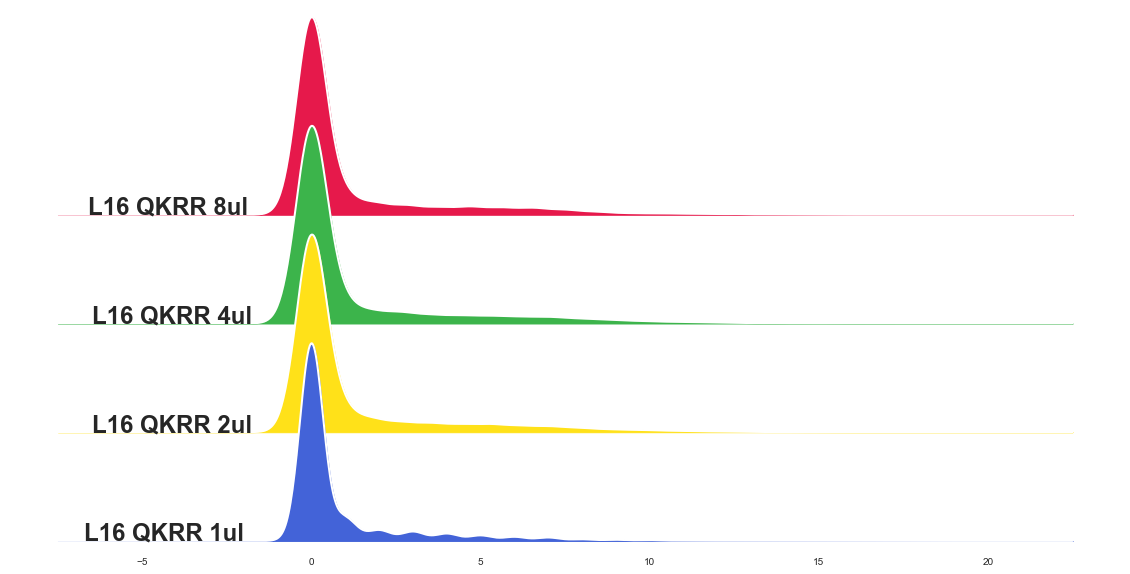

In [12]:
ridge_plot(data)